# Duality Robustness Simulation: Computational Analysis

This notebook contains the computational analyses and figure generation code related to the Michaelis-Menton genetic simulations for the manuscript. Execute all cells sequentially to reproduce the results and generate the accompanying figures.

## Prerequisites
- Ensure all required dependencies are installed
- Expected runtime: 40 minutes

## Output
Running this notebook will generate figures referenced in the manuscript and save them to the designated output directory.


In [1]:
%load_ext autoreload
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

# Import our refactored modules
import config
from dynamical_system import DynamicalSystem
from optimizer import RobustnessOptimizer
from data_loader import (load_network_data, get_network_pair, validate_network_data, 
                        create_control_matrices_from_eigenmodes, create_simple_control_matrices)
from visualization import (plot_mode_gap_evolution, plot_robustness_distribution, 
                          plot_robustness_tradeoff, plot_optimization_summary, 
                          print_optimization_summary, plot_eigenmode_analysis)

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [2]:
np.random.seed(400)

In [3]:
# Load network data (or create random data if files not available)
ks, Ks = load_network_data()
print(f"✓ Loaded {len(ks)} network matrices")
network_index = 0
k_net, K_net = get_network_pair(ks, Ks, network_index)
print(f"Using network index {network_index}")

print(f"Network shape: {k_net.shape}")
print(f"Network sparsity: {(k_net == 0).sum() / k_net.size * 100:.1f}%")

Loading k matrices from: many_ks.csv
Loading K matrices from: many_KKs.csv
Loaded 51 k matrices and 51 K matrices
Matrix dimensions: (30, 30)
✓ Loaded 51 network matrices
Using network index 0
Network shape: (30, 30)
Network sparsity: 78.2%


In [4]:

# Create random network
d = config.SYSTEM_DIMENSION
k = np.random.rand(d, d)
K = np.random.rand(d, d)

# Make it sparse
mask = k_net != 0
k[~mask] = 0
K[~mask] = 0
    
print(f"Created random {d}x{d} sparse network")

print(f"Network shape: {k.shape}")
print(f"Network sparsity: {(k == 0).sum() / k.size * 100:.1f}%")

Created random 30x30 sparse network
Network shape: (30, 30)
Network sparsity: 78.2%


In [5]:
# Create initial system without control
system = DynamicalSystem(
    k=k, K=K, lam=config.DECAY_VECTOR,
    k_p=0.0, k_i=0.0  # Start without control
)

# Find initial fixed point
initial_state = np.zeros(config.SYSTEM_DIMENSION) + 0.5
fixed_point = system.find_fixed_point(initial_state, config.SIMULATION_TIME)

print(f"Initial fixed point properties:")
print(f"  Total population: {np.sum(fixed_point):.4f}")
print(f"  Population range: [{np.min(fixed_point):.4f}, {np.max(fixed_point):.4f}]")
print(f"  Population std: {np.std(fixed_point):.4f}")

Initial fixed point properties:
  Total population: 7.8335
  Population range: [0.0430, 0.5348]
  Population std: 0.1331


NB this figure is purely for exploratory purposes, and is not included in the manuscript

Initial system properties:
  Mode gap: 1.535285
  IPR: 0.054713+0.000000j
  Slowest eigenvalue: -2.386653
  Second slowest eigenvalue: -3.664193


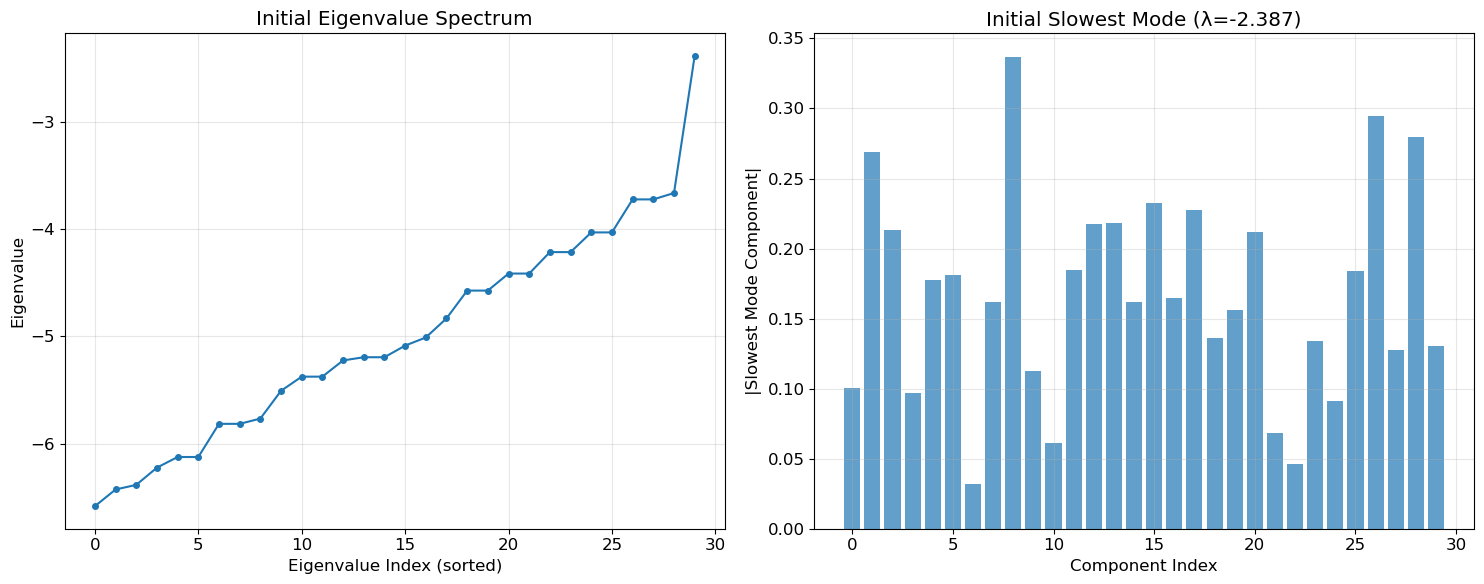

In [6]:
# Analyze initial eigenmodes
w_c, v, w = system.get_eigenmodes(fixed_point)
mode_gap_initial = system.calc_mode_gap(fixed_point)
ipr_initial = system.calc_ipr(fixed_point)

print(f"Initial system properties:")
print(f"  Mode gap: {mode_gap_initial:.6f}")
print(f"  IPR: {ipr_initial:.6f}")
print(f"  Slowest eigenvalue: {np.sort(w)[-1]:.6f}")
print(f"  Second slowest eigenvalue: {np.sort(w)[-2]:.6f}")

# Plot eigenvalue spectrum
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Eigenvalue spectrum
sorted_indices = np.argsort(w)
ax1.plot(range(len(w)), w[sorted_indices], 'o-', markersize=4)
ax1.set_xlabel('Eigenvalue Index (sorted)')
ax1.set_ylabel('Eigenvalue')
ax1.set_title('Initial Eigenvalue Spectrum')
ax1.grid(True, alpha=0.3)

# Slowest mode
slowest_mode = v[:, sorted_indices[-1]]
ax2.bar(range(len(slowest_mode)), np.abs(slowest_mode), alpha=0.7)
ax2.set_xlabel('Component Index')
ax2.set_ylabel('|Slowest Mode Component|')
ax2.set_title(f'Initial Slowest Mode (λ={w[sorted_indices[-1]]:.3f})')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# Create system with control
system_with_control = DynamicalSystem(
    k=k, K=K, lam=config.DECAY_VECTOR,
    k_p=config.PROPORTIONAL_GAIN, k_i=config.INTEGRAL_GAIN
)

In [8]:
np.random.seed(301)

strategy = "high_d"
print(f"Using {strategy} control strategy for optimization")
if strategy == 'low_d':
        _, v, _ = system.get_eigenmodes(fixed_point)
        n_control_channels = 1
        g, s = create_control_matrices_from_eigenmodes(v, n_control_channels)
if strategy == 'high_d':
        _, v, _ = system.get_eigenmodes(fixed_point)
        complex_list = []
        for i in range(0,v.shape[0]-1):
            if np.sum(np.real(v[:,i]) - np.real(v[:,i+1])) == 0:
                complex_list.append(i)
        current_g = np.array(v)
        for i in complex_list:
            current_g[:,i] = np.real(current_g[:,i])
            current_g[:,i+1] = np.imag(current_g[:,i+1])
        current_s = np.array(current_g).T
        current_s = current_s/np.linalg.norm(current_s,axis = 1)[:,None]
        current_g = current_g/np.linalg.norm(current_g,axis =0)[:,None]
        n_control_channels = 30
        g, s = current_g, current_s
# Create system with best control
system_for_optimization = DynamicalSystem(
    k=k, K=K, lam=config.DECAY_VECTOR,
    k_p=config.PROPORTIONAL_GAIN, k_i=config.INTEGRAL_GAIN
)

system_for_optimization.update_control_matrices(g, s)

# Create optimizer
optimizer = RobustnessOptimizer(system_for_optimization,cooling_rate = .999,temperature =  .3*config.INITIAL_TEMPERATURE)




# Run optimization with reduced iterations for demonstration
print("\nStarting optimization...")
optimization_iterations = 3000  # Reduced for demonstration

best_k_high_d, best_K_high_d, best_g, best_s, costs_high_d, mode_gaps_high_d = optimizer.optimize(
    initial_state, num_iterations=optimization_iterations, verbose=True
)

print(f"\nOptimization complete!")
print(f"Final cost: {costs[-1]:.6f}")
print(f"Final mode gap: {mode_gaps[-1]:.6f}")
print(f"Cost improvement: {((costs[0] - costs[-1]) / costs[0] * 100):.2f}%")

Using high_d control strategy for optimization

Starting optimization...


Cost: 0.0000, Mode Gap: 1.4778, Temp: 0.000149: 100%|█| 3000/3000 [14:53<00:00, 


Optimization complete!


NameError: name 'costs' is not defined

In [9]:
np.random.seed(301)

strategy = "low_d"
print(f"Using {strategy} control strategy for optimization")
if strategy == 'low_d':
        _, v, _ = system.get_eigenmodes(fixed_point)
        n_control_channels = 1
        g, s = create_control_matrices_from_eigenmodes(v, n_control_channels)
if strategy == 'high_d':
        _, v, _ = system.get_eigenmodes(fixed_point)
        complex_list = []
        for i in range(0,v.shape[0]-1):
            if np.sum(np.real(v[:,i]) - np.real(v[:,i+1])) == 0:
                complex_list.append(i)
        current_g = np.array(v)
        for i in complex_list:
            current_g[:,i] = np.real(current_g[:,i])
            current_g[:,i+1] = np.imag(current_g[:,i+1])
        current_s = np.array(current_g).T
        current_s = current_s/np.linalg.norm(current_s,axis = 1)[:,None]
        current_g = current_g/np.linalg.norm(current_g,axis =0)[:,None]
        n_control_channels = 30
        g, s = current_g, current_s
# Create system with best control
system_for_optimization = DynamicalSystem(
    k=k, K=K, lam=config.DECAY_VECTOR,
    k_p=config.PROPORTIONAL_GAIN, k_i=config.INTEGRAL_GAIN
)

system_for_optimization.update_control_matrices(g, s)

# Create optimizer
optimizer = RobustnessOptimizer(system_for_optimization,cooling_rate = .999,temperature =  .3*config.INITIAL_TEMPERATURE)


# Run optimization with reduced iterations for demonstration
print("\nStarting optimization...")
optimization_iterations = 3000  # Reduced for demonstration

best_k, best_K, best_g, best_s, costs_low_d, mode_gaps_low_d = optimizer.optimize(
    initial_state, num_iterations=optimization_iterations, verbose=True
)

print(f"\nOptimization complete!")
print(f"Final cost: {costs[-1]:.6f}")
print(f"Final mode gap: {mode_gaps[-1]:.6f}")
print(f"Cost improvement: {((costs[0] - costs[-1]) / costs[0] * 100):.2f}%")

Using low_d control strategy for optimization

Starting optimization...


Cost: 0.1055, Mode Gap: 23.5079, Temp: 0.000149: 100%|█| 3000/3000 [08:52<00:00,


Optimization complete!


NameError: name 'costs' is not defined

This creates figure 2c in the manuscript

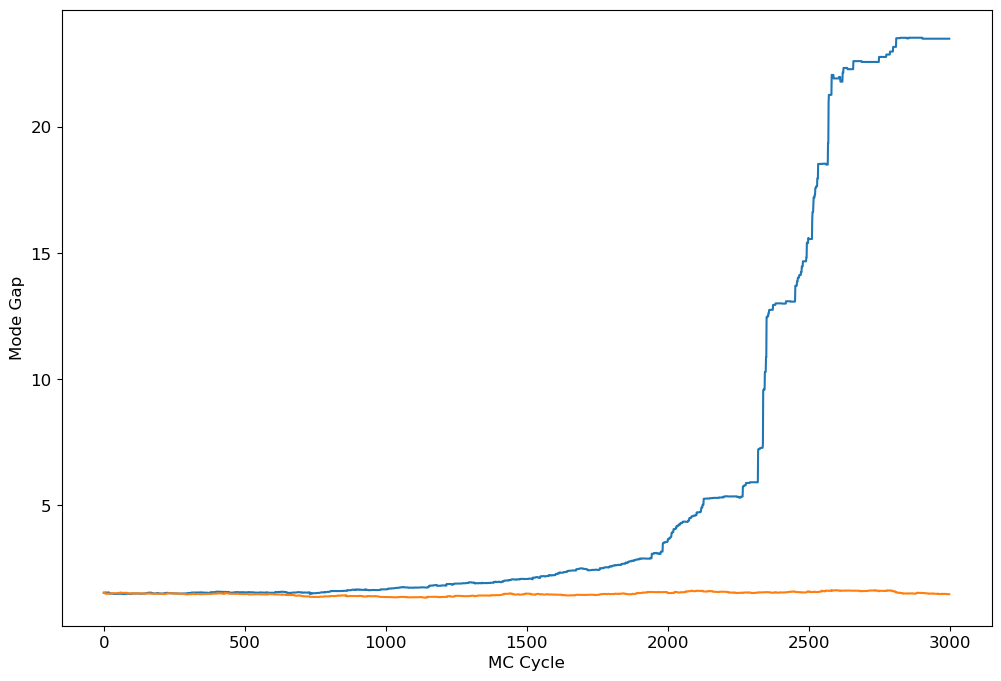

In [10]:
plt.rcParams['svg.fonttype'] = 'none'
plt.plot(mode_gaps_low_d,label = 'Low Dimensional Controller')

plt.plot(mode_gaps_high_d,label = 'High Dimensional Controller')
plt.xlabel('MC Cycle')
plt.ylabel('Mode Gap')
plt.savefig('figures/fig2c.svg', format='svg', bbox_inches='tight')
#plt.xlim([0,2100])
#plt.yscale('log')

In [11]:
system = DynamicalSystem(
    k=best_k, K=best_K, lam=config.DECAY_VECTOR,
    k_p=0.0, k_i=0.0  # Start without control
)

# Find initial fixed point
initial_state = np.zeros(config.SYSTEM_DIMENSION) + 0.5
best_fixed_point = system.find_fixed_point(initial_state, config.SIMULATION_TIME)
w_c, v, w = system.get_eigenmodes(fixed_point)
n_control_channels = 1
g, s = create_control_matrices_from_eigenmodes(v, n_control_channels)

In [12]:
np.random.seed(330)
is_connected = best_k != 0
connected_edges = np.nonzero(is_connected)
uncontrolled_dists = []
controlled_dists = []

for ii in tqdm(range(10000)):
    
    idx = np.random.randint(len(connected_edges[0]))
    i, j = connected_edges[0][idx], connected_edges[1][idx]
    
    k_pert = np.array(best_k)
    k_pert[i,j] += (np.random.rand() - 0.5)*.1
    K_pert = np.array(best_K)
    K_pert[i,j] += (np.random.rand() - 0.5)*.1

    system_with_control = DynamicalSystem(
        k=k_pert, K=K_pert, lam=config.DECAY_VECTOR,
        k_p=config.PROPORTIONAL_GAIN, k_i=config.INTEGRAL_GAIN
    )
    fixed_point = system_with_control.find_fixed_point(initial_state, config.SIMULATION_TIME)
    w_c, v, w = system_with_control.get_eigenmodes(fixed_point)
    if np.sum(w > 0) == 0:

        system_with_control.update_control_matrices(g, s)
        nt, _, _ = system_with_control.simulate(
                    best_fixed_point, np.zeros(system.l), config.SIMULATION_TIME, np.zeros(d), best_fixed_point, use_control=False
                )
        pert_fixed_point = nt[:, -1]
        uncontrolled_dists.append(np.linalg.norm(pert_fixed_point-best_fixed_point)) 
        nt, _, _ = system_with_control.simulate(
                    best_fixed_point, np.zeros(system.l), config.SIMULATION_TIME, np.zeros(d), best_fixed_point, use_control=True
                )
        pert_fixed_point = nt[:, -1]
        controlled_dists.append(np.linalg.norm(pert_fixed_point-best_fixed_point))

100%|█████████████████████████████████████| 10000/10000 [05:09<00:00, 32.35it/s]


This generates figure 4b in the manuscript

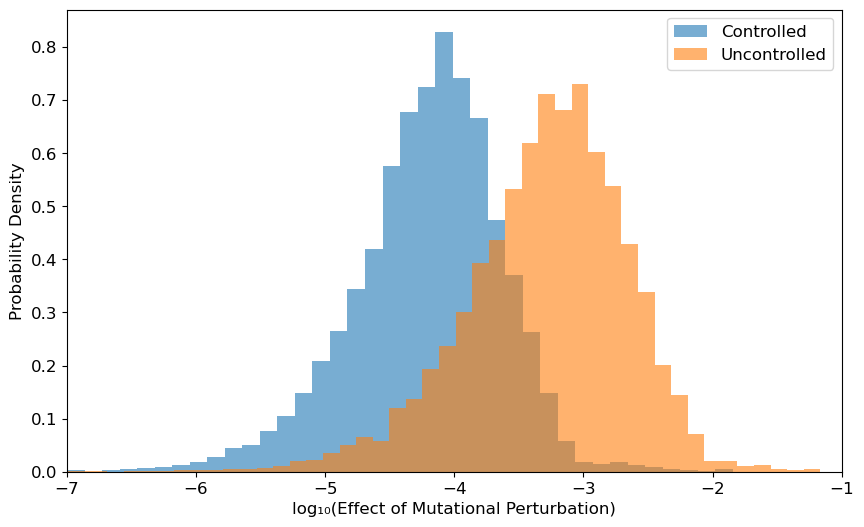

In [13]:
# Filter and log-transform data
controlled_data = np.array(controlled_dists)[np.log(controlled_dists) < 0]
uncontrolled_data = np.array(uncontrolled_dists)[np.log(uncontrolled_dists) < 0]

log_controlled = np.log10(controlled_data)
log_uncontrolled = np.log10(uncontrolled_data)

plt.figure(figsize=(10, 6))

# Use regular linear bins on log-transformed data
plt.hist(log_controlled, bins=50, density=True, alpha=0.6, 
         edgecolor='white', linewidth=0, label='Controlled')
plt.hist(log_uncontrolled, bins=50, density=True, alpha=0.6, 
         edgecolor='white', linewidth=0, label='Uncontrolled')
plt.xlim([-7,-1])
plt.xlabel('log₁₀(Effect of Mutational Perturbation)')
plt.ylabel('Probability Density')

plt.legend()
plt.savefig('figures/fig4b.svg', format='svg', bbox_inches='tight')


plt.show()

In [14]:
system_with_control = DynamicalSystem(
        k=best_k, K=best_K, lam=config.DECAY_VECTOR,
        k_p=config.PROPORTIONAL_GAIN, k_i=config.INTEGRAL_GAIN
    )

# Find initial fixed point
initial_state = np.zeros(config.SYSTEM_DIMENSION) + 0.5
best_fixed_point = system_with_control.find_fixed_point(initial_state, config.SIMULATION_TIME)
w_c, v, w = system.get_eigenmodes(fixed_point)
n_control_channels = 1
g, s = create_control_matrices_from_eigenmodes(v, n_control_channels)
system_with_control.update_control_matrices(g, s)

m = 20
uncontrolled_effects = np.zeros((d,m))
controlled_effects = np.zeros((d,m))

for i in range(m):
        # Apply perturbation to component i
        df = np.zeros(d)
        df[i] = config.PERTURBATION_STRENGTH

        # Test with control
        nt, _, _ = system_with_control.simulate(
            best_fixed_point, np.zeros(system_with_control.l), config.SIMULATION_TIME, df, best_fixed_point, use_control=True
        )
        controlled_effects[:,i] = nt[:, -1]

        # Test without control
        nt, _, _ = system_with_control.simulate(
            best_fixed_point, np.zeros(system_with_control.l), config.SIMULATION_TIME, df, best_fixed_point, use_control=False
        )
        uncontrolled_effects[:,i] = nt[:, -1]

This generates figure 5a in the manuscript

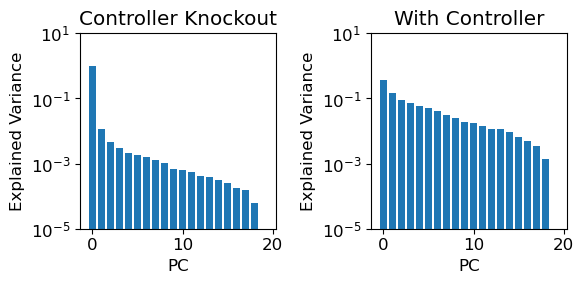

In [15]:
from sklearn.decomposition import PCA




pca1 = PCA()
pca2 = PCA()
pca1.fit(controlled_effects.T)
pca2.fit(uncontrolled_effects.T)

# Plot side by side
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 2)
plt.bar(range(len(pca1.explained_variance_ratio_)), pca1.explained_variance_ratio_)
plt.ylim([10**-5,10])
plt.yscale('log')
plt.title('With Controller')
plt.xlabel('PC')

plt.ylabel('Explained Variance')

plt.subplot(1, 2, 1)
plt.bar(range(len(pca2.explained_variance_ratio_)), pca2.explained_variance_ratio_)
plt.title('Controller Knockout')
plt.ylim([10**-5,10])
plt.yscale('log')
plt.xlabel('PC')

plt.ylabel('Explained Variance')
plt.savefig('figures/fig5a.svg', format='svg', bbox_inches='tight')

plt.tight_layout()
plt.show()